## EDA

- Exploración del dataset.
- Visualización de distribuciones.

### Carga de librerías y configuración

In [1]:
# Importación de librerías
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from ast import literal_eval


plt.rcParams["figure.figsize"] = (8,4)

# Carpeta para guardar figuras
REPORTS_DIR = Path("../informes/figuras")
REPORTS_DIR.mkdir(parents=True, exist_ok=True)

### Carga de dataset original

In [2]:
df = pd.read_pickle("../data/orig/FraudNLP_dataset.pkl")
action_vocab = pd.read_csv("../data/orig/vocab.csv")

# Sanity check
broken_times = df[df.times.apply(lambda x: x[-1]!="]")]
assert broken_times.shape[0] == 1
assert broken_times.iloc[0].is_fraud==0

# Ignorar la fila corrupta
df = df[df.times.apply(lambda x: x[-1]=="]")]

# Preprocesamiento de las acciones
action_names = action_vocab.Name.to_list()
id_to_action = {str(i):a for i,a in enumerate(action_names)}
action_to_id = {a:str(i) for i,a in enumerate(action_names)}
df.actions = df.actions.apply(literal_eval)
df['n_actions'] = df['actions'].apply(len)
df.head(2)

,actions,times,execution_time,Amount,device_freq,ip_freq,beneficiary_freq,application_freq,is_fraud,n_actions
1,"[[22], [27], [24], [1], [1268], [1269], [1267]...","[0, 33204.0, 215636.0, 443415.0, 72586.0, 3424...",203,13,1.0,1.000000,0.500000,1.0,0,24
2,"[[22], [24], [27], [1], [1268], [1269], [1267]...","[0, 25459.0, 46236.0, 428626.0, 42785.0, 74158...",359,310,1.0,0.333333,0.333333,1.0,0,2983


### Exploración sencilla

In [3]:
print("Dimensiones del dataset:", df.shape)
print("\nDistribución de clases (%):")
print(df["is_fraud"].value_counts(normalize=True) * 100)

Dimensiones del dataset: (105302, 10)

Distribución de clases (%):
is_fraud
0    99.904085
1     0.095915
Name: proportion, dtype: float64


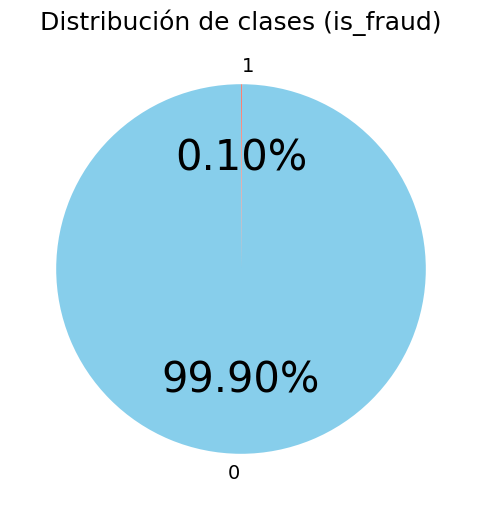

In [4]:
# Gráfico circular
dist = df["is_fraud"].value_counts(normalize=True) * 100
fig, ax = plt.subplots(figsize=(6, 6))
wedges, texts, autotexts = ax.pie(
    dist,
    labels=dist.index,
    autopct="%.2f%%",
    startangle=90,
    colors=["skyblue", "salmon"],
    textprops={"fontsize": 14}  # tamaño para las etiquetas
)
# Ajustar tamaño de los porcentajes
for autotext in autotexts:
    autotext.set_fontsize(30)
    autotext.set_color("black")   # opcional, para mejorar contraste

ax.set_title("Distribución de clases (is_fraud)", fontsize=18)
plt.savefig("../informes/figuras/pie.png", transparent=True)  # exporta con fondo transparente
plt.show()

In [5]:
print(f'Importe máximo: {df["Amount"].max():.2f} €')
print(f'Importe mínimo: {df["Amount"].min():.2f} €')
print(f'Importe medio: {df["Amount"].mean():.2f} €')
print(f'Importe mediano: {df["Amount"].median():.2f} €')

Importe máximo: 1500000.00 €
Importe mínimo: 0.00 €
Importe medio: 468.80 €
Importe mediano: 100.00 €


In [6]:
faltantes = df.isnull().sum().to_frame("n_faltantes")
faltantes["pct_faltantes"] = (df.isnull().mean() * 100).round(2)
print(faltantes)

                  n_faltantes  pct_faltantes
actions                     0            0.0
times                       0            0.0
execution_time              0            0.0
Amount                      0            0.0
device_freq                 0            0.0
ip_freq                     0            0.0
beneficiary_freq            0            0.0
application_freq            0            0.0
is_fraud                    0            0.0
n_actions                   0            0.0


#### Distribución de importes

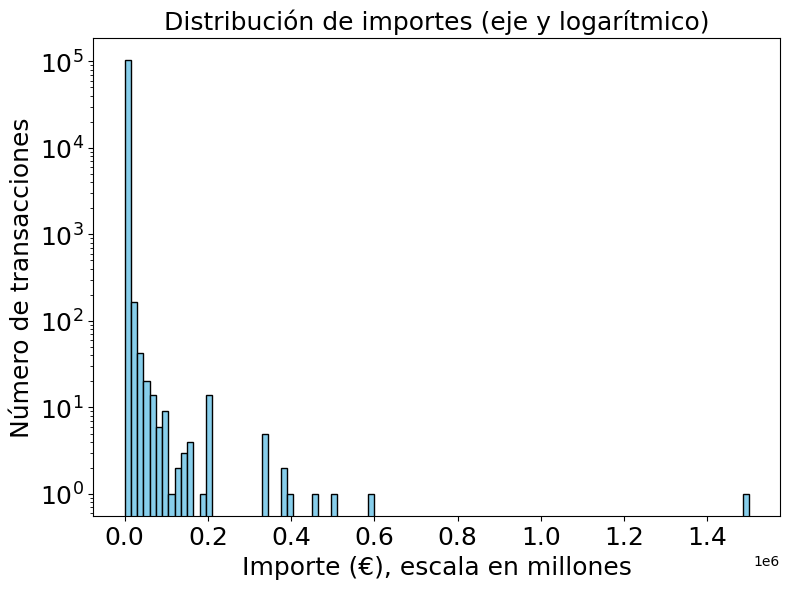

In [7]:
plt.figure(figsize=(8, 6))
plt.hist(df["Amount"], bins=100, color="skyblue", edgecolor="black")
plt.title("Distribución de importes (eje y logarítmico)", fontsize=18)
plt.xlabel("Importe (€), escala en millones", fontsize=18)
plt.ylabel("Número de transacciones", fontsize=18)
plt.yscale("log")

# Aumentar tamaño de los números en los ejes
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

plt.tight_layout()
plt.savefig(REPORTS_DIR/"dist_importes.png", bbox_inches="tight", dpi=250)
plt.show()

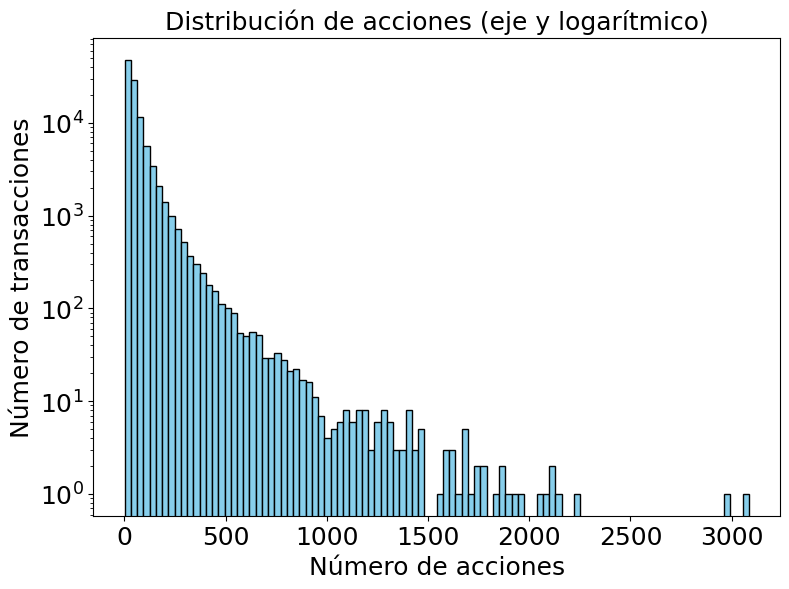

In [8]:
# Distribución de acciones
plt.figure(figsize=(8, 6))
plt.hist(df["n_actions"], bins=100, color="skyblue", edgecolor="black")
plt.title("Distribución de acciones (eje y logarítmico)", fontsize=18)
plt.xlabel("Número de acciones", fontsize=18)
plt.ylabel("Número de transacciones", fontsize=18)
plt.yscale('log')
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.tight_layout()
plt.savefig(REPORTS_DIR/"dist_acciones.png", bbox_inches="tight", dpi=250)
plt.show()

### Correlaciones

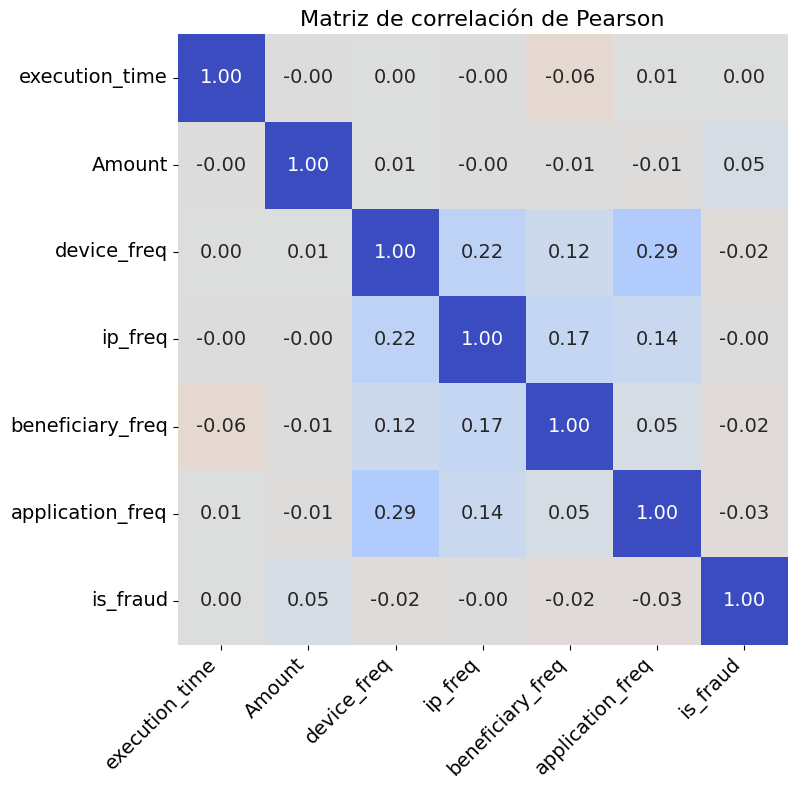

In [9]:
df_corr = df.copy().drop(columns=["times", "actions", "n_actions"])
corr = df_corr.corr()

plt.figure(figsize=(10, 8))
ax = sns.heatmap(
    corr,
    cmap="coolwarm_r",
    square=True,
    annot=True,
    fmt=".2f",
    vmin=-1, vmax=1,
    cbar=False,
    annot_kws={'size': 14}
)

# Cambiar tamaño de los labels de los ejes
ax.set_xticklabels(ax.get_xticklabels(), fontsize=14, rotation=45, ha="right")
ax.set_yticklabels(ax.get_yticklabels(), fontsize=14, rotation=0)

plt.title("Matriz de correlación de Pearson", fontsize=16)
plt.tight_layout()
plt.savefig(REPORTS_DIR/"matriz_correlacion.png", bbox_inches="tight", dpi=250)
plt.show()

## Conclusiones
- El dataset está **muy desbalanceado**: el fraude es extremadamente raro (<0.1%).
- La distribución de importes y número de acciones es muy sesgada hacia valores bajos.
- No existen correlaciones notables entre las variables.